In [1]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 181 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 49.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b5b658edf762913108a23b0ff4bbf4bd941f0e16cdb82a9f197fd75af4c47905
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [3]:
TRAIN_PATH = "hi.translit.sampled.train.tsv"
VAL_PATH = "hi.translit.sampled.dev.tsv"
TEST_PATH = "hi.translit.sampled.test.tsv"

df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, error_bad_lines=False).dropna()
hindi_words = [list(f'\t{word}\n') for word in df[0].tolist()]
english_words = [list(f'\t{word}\n') for word in df[1].tolist()]
# Creating sorted vocabulary of source and target language
english_characters = sorted(list(set([char for word in english_words for char in word])))
hindi_characters = sorted(list(set([char for word in hindi_words for char in word])))
# Creating essential parameters
max_encoder_seq_length = (np.max([len(i) for i in english_words]))
max_decoder_seq_length = (np.max([len(i) for i in hindi_words]))
num_encoder_tokens = len(english_characters)
num_decoder_tokens = len(hindi_characters)
# Mapping each character of vocabulary to index and vice versa
input_token_index = dict([(char, i) for i, char in enumerate(english_characters)])
inverse_input_token_index = {v: k for k, v in input_token_index.items()}
target_token_index = dict([(char, i) for i, char in enumerate(hindi_characters)])
inverse_target_token_index = {v: k for k, v in target_token_index.items()}

def load_encoder_decoder_data(filepath, sep='\t', header=None):
  df = pd.read_csv(filepath, sep=sep, header=header, error_bad_lines=False).dropna()
  decoder_target_data = np.zeros((df.shape[0],max_decoder_seq_length,num_decoder_tokens), dtype="float32")
  for i, hindi_text in enumerate(df[0].tolist()):
      hindi_text = f'\t{hindi_text}\n'
      for t, char in enumerate(hindi_text):
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_target_data[i, t:, target_token_index["\n"]] = 1.0
  encoder_input_data = []
  for word in df[1].tolist():
    encoder_input_data.append([input_token_index[char] for char in f'\t{word}\n'])
  encoder_input_data = sequence.pad_sequences(encoder_input_data, maxlen=max_encoder_seq_length, padding="post")
  decoder_input_data = []
  for word in df[0].tolist():
    decoder_input_data.append([target_token_index[char] for char in f'\t{word}\n'])
  decoder_input_data = sequence.pad_sequences(decoder_input_data, maxlen=max_decoder_seq_length, padding="post")
  return encoder_input_data, decoder_input_data, decoder_target_data

# Train split
train_encoder_input_data, train_decoder_input_data, train_decoder_target = load_encoder_decoder_data(TRAIN_PATH)
# Validation split
val_encoder_input_data, val_decoder_input_data, val_decoder_target = load_encoder_decoder_data(VAL_PATH)
# Test split
test_encoder_input_data, test_decoder_input_data, test_decoder_target = load_encoder_decoder_data(TEST_PATH)

buffer_size = 100000

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




In [4]:
class BahdanauAttention(Layer):
  def __init__(self, units):
    super().__init__()
    self.W_decoder = Dense(units)
    self.W_encoder = Dense(units)
    self.W_aggregate = Dense(1)

  def call(self, query, values):
    query_across_time = tf.expand_dims(query, 1)
    decoder_transform = self.W_decoder(query_across_time)
    encoder_transform = self.W_encoder(values)
    score = tf.nn.tanh(encoder_transform + decoder_transform)
    score = self.W_aggregate(score)
    attention_weights = tf.nn.softmax(score, axis=1)
    context = tf.reduce_sum((attention_weights * values), axis=1)
    return context, attention_weights


class Encoder(Model):
  def __init__(self, config):
    super(Encoder, self).__init__()
    self.config = config
    
    # Embedding layer: (num_encoder_tokens, input_embedding_size)
    self.encoder_embedding = Embedding(num_encoder_tokens, self.config.input_embedding_size, name='Encoder_embeddings')
    
    # Adding encoder layer
    self.get_cell = {
        'rnn': SimpleRNN(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'gru': GRU(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'lstm': LSTM(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
    }
    self.encoder_cell = self.get_cell[self.config.cell_type]


  def call(self, encoder_input, hidden):
    encoder_embedded = self.encoder_embedding(encoder_input)
    if self.config.cell_type in ['rnn', 'gru']:
        output, state = self.get_cell[self.config.cell_type](encoder_embedded, initial_state=hidden)
    elif self.config.cell_type == "lstm":
        output, state, context= self.get_cell[self.config.cell_type](encoder_embedded, initial_state=hidden)
    return output, state

  def init_hidden_states(self):
      if self.config.cell_type in ['rnn', 'gru']:
          return tf.zeros((self.config.batch_size, self.config.hidden_units))
      else:
        return (tf.zeros((self.config.batch_size, self.config.hidden_units)),
                  tf.zeros((self.config.batch_size, self.config.hidden_units)))
        
class Decoder(Model):
  def __init__(self, config):
    super(Decoder, self).__init__()
    self.config = config
    # Attention Layer
    self.attention = BahdanauAttention(self.config.hidden_units)
    
    # Embedding layer: (num_decoder_tokens, input_embedding_size)
    self.decoder_embedding = Embedding(num_decoder_tokens, self.config.input_embedding_size)
    
    # Output dense layer: (num_decoder_tokens)
    self.decoder_dense = Dense(num_decoder_tokens)
    
    # Adding decoder layer
    self.get_cell = {
        'rnn': SimpleRNN(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'gru': GRU(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
        'lstm': LSTM(self.config.hidden_units, dropout=self.config.dropout, 
                   return_sequences=True, return_state=True,
                   recurrent_initializer=self.config.initializer, name=f"Encoder_0"),
    }
    self.decoder_cell = self.get_cell[self.config.cell_type]

  def call(self, decoder_inputs, hidden, encoder_output):
    context, attention_weights = self.attention(hidden, encoder_output)
    decoder_embedded = self.decoder_embedding(decoder_inputs)
    concatenated = tf.concat([tf.expand_dims(context, 1), decoder_embedded], axis=-1)
    if self.config.cell_type in ['rnn', 'gru']:
        output, state = self.get_cell[self.config.cell_type](concatenated)
    elif self.config.cell_type == "lstm":
        output, state, context= self.get_cell[self.config.cell_type](concatenated)
    output = self.decoder_dense(tf.reshape(output, (-1, output.shape[2])))
    return output, state, attention_weights

In [9]:
class TransliterationAttentionModel:
    def __init__(self, config):
        self.config = config
        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
        self.optimizer = Adam(learning_rate=self.config.learning_rate)
        self.loss_func = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    @tf.function()    
    def train_one_batch(self, encoder_inputs, decoder_targets):
        loss = 0
        # Initialize hidden states to zeroes
        encoder_hidden = self.encoder.init_hidden_states()
        with tf.GradientTape() as tape:
            encoder_output, decoder_hidden = self.encoder(encoder_inputs, encoder_hidden)
            decoder_input = tf.expand_dims([target_token_index['\t']] * self.config.batch_size, 1)
            for t in range(1, decoder_targets.shape[1]):
                decoder_output, decoder_hidden, attention_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
                batch_loss = self.loss_func(decoder_targets[:, t], decoder_output)
                # Ignore pad index
                batch_loss *= tf.cast(tf.math.logical_not(tf.math.equal(decoder_targets[:, t], 0)), dtype=batch_loss.dtype)
                batch_loss = tf.reduce_mean(batch_loss)
                dec_input = tf.expand_dims(decoder_targets[:, t], 1)
                loss += batch_loss
        gradients = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.attention.trainable_variables + self.decoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables + self.decoder.attention.trainable_variables + self.decoder.trainable_variables))
        return (loss / decoder_targets.shape[1])

    def train(self, dataset, batch_size, num_batches):
        for epoch in range(1, self.config.epochs+1):
            loss = 0
            # Iterate batches over dataset and train 
            for (batch, (encoder_inputs, decoder_targets)) in tqdm(enumerate(dataset.take(num_batches))):
                batch_loss = self.train_one_batch(encoder_inputs, decoder_targets)
                loss += batch_loss 
            print(f'Epoch {epoch} Loss {loss/num_batches:.4f}')
    
    def calculate_accuracy(self, split='test'):
        correct, total = 0, 0
        targets, predicted, english_words = [], [], []
        for i in range(len(test_decoder_input_data)):
            gt = ""  # fetch ground truth
            for token in test_decoder_input_data[i][1:]:
                if inverse_target_token_index[token]!="\n":
                    gt += inverse_target_token_index[token]
                else:
                    break
            english = ""  # fetch english word
            for token in test_encoder_input_data[i][1:]:
                if inverse_input_token_index[token]!="\n":
                    english += inverse_input_token_index[token]
                else:
                    break
            pred = self.get_predicted_word(test_encoder_input_data[i])
            if i % 100 == 0:
              print("english: ", english, "gt: ",gt," pred: ",pred)
            if gt == pred :
                correct += 1
            total += 1
            targets.append(gt)
            predicted.append(pred)
            english_words.append(english)
        import pandas as pd
        df=pd.DataFrame({'English': english_words, 'Predicted': predicted, 'Target': targets})
        df.to_csv('predictions_attention.csv')
        word_test_accuracy = correct / total
        print("test accuracy : " ,word_test_accuracy )
    
    def get_predicted_word(self, inputs):
        if self.config.cell_type in ['rnn', 'gru']:
            hidden = [tf.zeros((1, self.config.hidden_units))]
        else:
            hidden = [tf.zeros((1, self.config.hidden_units)),
                      tf.zeros((1, self.config.hidden_units))]          
        encoder_input = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
        encoder_output, decoder_hidden = self.encoder(encoder_input, hidden)
        decoder_input = tf.expand_dims([target_token_index['\t']], 0)  # start token
        predicted_word = ''
        all_attention_weights = np.zeros((max_decoder_seq_length,max_encoder_seq_length))
        for t in range(max_decoder_seq_length):
            decoder_output, decoder_hidden, attention_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
            token = np.argmax(decoder_output[0].numpy())
            all_attention_weights[t] = attention_weights.numpy().reshape(-1)
            if inverse_target_token_index[token] != "\n":  # end token
                predicted_word += inverse_target_token_index[token]
            else:
                return predicted_word, all_attention_weights
            decoder_input = tf.expand_dims([token], 0) 
        return predicted_word, all_attention_weights

In [6]:
# Best hyperparameter configuration
cfg_dict = {'batch_size': 256, 'cell_type': 'lstm', 'dropout': 0.3, 'epochs': 20, 'hidden_units': 256, 'initializer': 'orthogonal', 'input_embedding_size': 256, 'learning_rate': 0.002}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config = dotdict(cfg_dict)
num_batches = len(train_encoder_input_data)//config.batch_size
dataset = tf.data.Dataset.from_tensor_slices((train_encoder_input_data, train_decoder_input_data)).shuffle(buffer_size)
dataset = dataset.batch(config.batch_size, drop_remainder=True)
model = TransliterationAttentionModel(config)
model.train(dataset, config.batch_size, num_batches)

172it [01:20,  2.15it/s]


Epoch 1 Loss 1.1480


172it [00:29,  5.82it/s]


Epoch 2 Loss 0.9356


172it [00:29,  5.84it/s]


Epoch 3 Loss 0.5503


172it [00:29,  5.83it/s]


Epoch 4 Loss 0.4209


172it [00:29,  5.84it/s]


Epoch 5 Loss 0.3745


172it [00:29,  5.79it/s]


Epoch 6 Loss 0.3419


172it [00:29,  5.83it/s]


Epoch 7 Loss 0.3245


172it [00:29,  5.81it/s]


Epoch 8 Loss 0.3009


172it [00:29,  5.82it/s]


Epoch 9 Loss 0.2850


172it [00:29,  5.81it/s]


Epoch 10 Loss 0.2665


172it [00:29,  5.83it/s]


Epoch 11 Loss 0.2639


172it [00:29,  5.85it/s]


Epoch 12 Loss 0.2484


172it [00:29,  5.83it/s]


Epoch 13 Loss 0.2443


172it [00:29,  5.81it/s]


Epoch 14 Loss 0.2305


172it [00:29,  5.80it/s]


Epoch 15 Loss 0.2217


172it [00:29,  5.82it/s]


Epoch 16 Loss 0.2178


172it [00:29,  5.80it/s]


Epoch 17 Loss 0.2097


172it [00:29,  5.80it/s]


Epoch 18 Loss 0.2025


172it [00:29,  5.83it/s]


Epoch 19 Loss 0.2057


172it [00:29,  5.80it/s]


Epoch 20 Loss 0.2040


### Visualize Connectivity

In [ ]:
!pip install mycolorpy

In [110]:
from IPython.display import HTML as html_print
from IPython.display import display
from mycolorpy import colorlist as mcp

rgb_colors = mcp.gen_color(cmap="bwr",n=20)

def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

def get_color(value):
    value = int(value * 100) // 5
    value = 19 if value > 19 else value
    return rgb_colors[value]

done, correct, total = 0, 0, 0
targets, predicted, english_words = [], [], []
# Iterate over test set
for i in range(0, len(test_decoder_input_data), 19):
    gt = ""  # fetch ground truth
    for token in test_decoder_input_data[i][1:]:
        if inverse_target_token_index[token]!="\n":
            gt += inverse_target_token_index[token]
        else:
            break
    english = ""  # fetch english word
    for token in test_encoder_input_data[i][1:]:
        if inverse_input_token_index[token]!="\n":
            english += inverse_input_token_index[token]
        else:
            break
    inputs = test_encoder_input_data[i]
    gradients = []
    # Track gradients of decoder output w.r.t encoder embeddings (Embedding layer is not diff. in Keras)
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        if model.config.cell_type in ['rnn', 'gru']:
            hidden = [tf.zeros((1, model.config.hidden_units))]
        else:
            hidden = [tf.zeros((1, model.config.hidden_units)),
                  tf.zeros((1, model.config.hidden_units))]          
        encoder_input = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
        encoder_output, decoder_hidden = model.encoder(encoder_input, hidden)
        encoder_embedded = model.encoder.encoder_embedding(encoder_input)
        tape.watch(encoder_embedded)
        encoder_output, decoder_hidden, _ = model.encoder.get_cell[model.config.cell_type](encoder_embedded, initial_state=hidden)        
        decoder_input = tf.expand_dims([target_token_index['\t']], 0)  # start token
        predicted_word = ''
        all_attention_weights = np.zeros((max_decoder_seq_length,max_encoder_seq_length))
        # Decode inputs
        for t in range(max_decoder_seq_length):
            decoder_output, decoder_hidden, attention_weights = model.decoder(decoder_input, decoder_hidden, encoder_output)
            gradients.append(tape.gradient(decoder_output, encoder_embedded)[0])
            token = np.argmax(decoder_output[0].numpy())  # greedy
            all_attention_weights[t] = attention_weights.numpy().reshape(-1)
            if inverse_target_token_index[token] != "\n":  # end token
                predicted_word += inverse_target_token_index[token]
            else:
                break
            decoder_input = tf.expand_dims([token], 0) 
        pred = predicted_word
        if pred == gt and (True not in tf.math.is_nan(gradients).numpy()):
          done += 1
          print('-'*20)
          print("english: ", english, "gt: ",gt," pred: ",pred)
          # Normalize gradients for visualization
          norm_gradients = np.array(gradients)
          norm_gradients = np.linalg.norm(norm_gradients, axis=-1)
          norm_gradients = norm_gradients / np.max(norm_gradients, axis=-1).reshape(-1, 1)
          # Generate Visualization
          for i in range(len(pred)):
            print("Decoding ", pred[i]," → ", end='')
            text_colors = [(english[j], get_color(norm_gradients[i][j])) for j in range(len(english))]
            print_color(text_colors)
    if done > 10:
      break

--------------------
english:  agra gt:  अग्र  pred:  अग्र
Decoding  अ  → 

Decoding  ग  → 

Decoding  ्  → 

Decoding  र  → 

--------------------
english:  amuk gt:  अमुक  pred:  अमुक
Decoding  अ  → 

Decoding  म  → 

Decoding  ु  → 

Decoding  क  → 

--------------------
english:  arthon gt:  अर्थों  pred:  अर्थों
Decoding  अ  → 

Decoding  र  → 

Decoding  ्  → 

Decoding  थ  → 

Decoding  ो  → 

Decoding  ं  → 

--------------------
english:  aagaman gt:  आगमन  pred:  आगमन
Decoding  आ  → 

Decoding  ग  → 

Decoding  म  → 

Decoding  न  → 

--------------------
english:  ishita gt:  इशिता  pred:  इशिता
Decoding  इ  → 

Decoding  श  → 

Decoding  ि  → 

Decoding  त  → 

Decoding  ा  → 

--------------------
english:  emile gt:  एमिल  pred:  एमिल
Decoding  ए  → 

Decoding  म  → 

Decoding  ि  → 

Decoding  ल  → 

--------------------
english:  kachche gt:  कच्चे  pred:  कच्चे
Decoding  क  → 

Decoding  च  → 

Decoding  ्  → 

Decoding  च  → 

Decoding  े  → 

--------------------
english:  jayke gt:  जायके  pred:  जायके
Decoding  ज  → 

Decoding  ा  → 

Decoding  य  → 

Decoding  क  → 

Decoding  े  → 

--------------------
english:  jeevan gt:  जीवन  pred:  जीवन
Decoding  ज  → 

Decoding  ी  → 

Decoding  व  → 

Decoding  न  → 

--------------------
english:  jain gt:  जैन  pred:  जैन
Decoding  ज  → 

Decoding  ै  → 

Decoding  न  → 

--------------------
english:  trot gt:  ट्रॉट  pred:  ट्रॉट
Decoding  ट  → 

Decoding  ्  → 

Decoding  र  → 

Decoding  ॉ  → 

Decoding  ट  → 

In [113]:
# Repeat for incorrectly classified examples

from IPython.display import HTML as html_print
from IPython.display import display
from mycolorpy import colorlist as mcp

rgb_colors = mcp.gen_color(cmap="bwr",n=20)

def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

def get_color(value):
    value = int(value * 100) // 5
    value = 19 if value > 19 else value
    return rgb_colors[value]

done, correct, total = 0, 0, 0
targets, predicted, english_words = [], [], []
# Iterate over test set
for i in range(19, len(test_decoder_input_data), 19):
    gt = ""  # fetch ground truth
    for token in test_decoder_input_data[i][1:]:
        if inverse_target_token_index[token]!="\n":
            gt += inverse_target_token_index[token]
        else:
            break
    english = ""  # fetch english word
    for token in test_encoder_input_data[i][1:]:
        if inverse_input_token_index[token]!="\n":
            english += inverse_input_token_index[token]
        else:
            break
    inputs = test_encoder_input_data[i]
    gradients = []
    # Track gradients of decoder output w.r.t encoder embeddings (Embedding layer is not diff. in Keras)
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        if model.config.cell_type in ['rnn', 'gru']:
            hidden = [tf.zeros((1, model.config.hidden_units))]
        else:
            hidden = [tf.zeros((1, model.config.hidden_units)),
                  tf.zeros((1, model.config.hidden_units))]          
        encoder_input = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
        encoder_output, decoder_hidden = model.encoder(encoder_input, hidden)
        encoder_embedded = model.encoder.encoder_embedding(encoder_input)
        tape.watch(encoder_embedded)
        encoder_output, decoder_hidden, _ = model.encoder.get_cell[model.config.cell_type](encoder_embedded, initial_state=hidden)        
        decoder_input = tf.expand_dims([target_token_index['\t']], 0)  # start token
        predicted_word = ''
        all_attention_weights = np.zeros((max_decoder_seq_length,max_encoder_seq_length))
        # Decode inputs
        for t in range(max_decoder_seq_length):
            decoder_output, decoder_hidden, attention_weights = model.decoder(decoder_input, decoder_hidden, encoder_output)
            gradients.append(tape.gradient(decoder_output, encoder_embedded)[0])
            token = np.argmax(decoder_output[0].numpy())  # greedy
            all_attention_weights[t] = attention_weights.numpy().reshape(-1)
            if inverse_target_token_index[token] != "\n":  # end token
                predicted_word += inverse_target_token_index[token]
            else:
                break
            decoder_input = tf.expand_dims([token], 0) 
        pred = predicted_word
        if pred != gt and (True not in tf.math.is_nan(gradients).numpy()):
          done += 1
          print('-'*20)
          print("english: ", english, "gt: ",gt," pred: ",pred)
          # Normalize gradients for visualization
          norm_gradients = np.array(gradients)
          norm_gradients = np.linalg.norm(norm_gradients, axis=-1)
          norm_gradients = norm_gradients / np.max(norm_gradients, axis=-1).reshape(-1, 1)
          # Generate Visualization
          for i in range(len(pred)):
            print("Decoding ", pred[i]," → ", end='')
            text_colors = [(english[j], get_color(norm_gradients[i][j])) for j in range(len(english))]
            print_color(text_colors)
    if done > 2:
      break

--------------------
english:  andrabi gt:  अंद्राबी  pred:  अंद्बी
Decoding  अ  → 

Decoding  ं  → 

Decoding  द  → 

Decoding  ्  → 

Decoding  ब  → 

Decoding  ी  → 

--------------------
english:  adhivas gt:  अधिवास  pred:  अधिवा
Decoding  अ  → 

Decoding  ध  → 

Decoding  ि  → 

Decoding  व  → 

Decoding  ा  → 

--------------------
english:  anawashyak gt:  अनावश्यक  pred:  अनााश्ा
Decoding  अ  → 

Decoding  न  → 

Decoding  ा  → 

Decoding  ा  → 

Decoding  श  → 

Decoding  ्  → 

Decoding  ा  → 

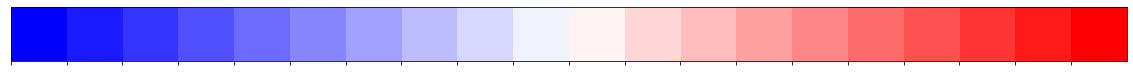

In [129]:
import seaborn as sns
sns.palplot(rgb_colors)